# Modelling approach

We take multiple approaches to predict the variant played on a given board.  
The **trade-off between accuracy and computational capacities** plays an important role in the analysis. We are working on a sample of 9000 observations and might already face some computational complexity issues, which could grow exponentially when using more samples. While **maximising the accuracy is the main objective** of the project, we will keep an eye on the **complexity** of the models. Therefore, we record the **computation time as a proxy of the computational complexity** of a given model.  
More precisely, we record the accuracy on the testing set, the tuning time using grid-search cross-validation, the training time for each of the evaluated models as well as the recall, precision and F1 scores for the blitz variant (as is the most "important" and played variant, we give a particular attention to it) and on average.    

The different approches consist of predicting the variants using different sets of data, different models and including PCA or not.  

We present in this Jupyter notebook the different steps that are applied to the "full" dataframe, incorporating all the features that have been encoded from the board as well as the engineered features. The approach is commented.  

In the Jupyter notebook "2.1 Capstone project - Eng.ipynb", the different models based only on engineered features are presented. The results are commented, but the methodology not presented again.  
In the Jupyter notebook "2.2 Capstone project - PCA.ipynb", we use a PCA on the full dataset and run the usual procedure. The results are commented, as well as the rational for choosing the PCA.  
In the Jupyter notebook "2.3.0 Capstone project - Nested models.ipynb" and its copies, we use a nested strategy, using a 2-step process. The results are commented in the "2.4.0 Capstone project - Nested models.ipynb" and only shown on its copies.  
In the Jupyter notebook "2.4 Capstone project - NN.ipynb", we run a neural network on a training sample of 5000 games per variant (45000 games) and comment the fidings.  

The results and the comparison of the different approaches are then presented in the notebook "Capstone project - Results.ipynb".

# Baseline model

We have 9 different variants and a baseline accuracy of 11.1%.  
If we ignore the Horde and Racing Kings variants, for which we can expect an accuracy close to 100%, we are left with 7 variants and a baseline of 1/7 = 14.3% for these 7 variants.   

The baseline accuracy that we will use is therefore of 2/9 * 100% + 7/9 * 1/7 = 39.7%.  
The goal will be to improve this baseline.  

---
# Summary of the methodology and outcomes for the approach using the full dataset:

In this notebook, we use the "full dataset" (full_df) to predict the variants. We start by spliting the data into a training set and a testing set. The same split will be applied for all the futures approaches for comparison reasons.  
We start by fitting a decision tree that gives us more insights on the data. The number of pawns, captures, checks or moves are important features. Rooks placed on the corner squares of the board also have an edge to play.  

We then fit the other models (logistic regression, random forest, support vector machines and neural network, always using a grid search cross validation.  

In terms of modelling, the SVM model outperforms the other models and we reach an accuracy of 88%. This is clearly above the baseline and seems very promising. This will probably be the score to beat using the other approaches.  

---
# Modelling

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

We start by loading the dataset of interest that we saved previously. 

In [2]:
full_df = pd.read_pickle('datasets/full_df')

In [3]:
variants = ['antichess', 'atomic', 'blitz', 'chess960', 'crazyhouse', 'horde', 'kingOfTheHill', 'racingKings', 'threeCheck']

# Creating Train/Validation/Test set

As we use a cross validation strategy, we can work only with two sets of data: 
- the training set: it will be further split into training/validation sets in the different iterations of the cross validation ;  
- the testing set: unseen data that will be used only once the models are tuned to evaluate the final accuracy. 

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(
     full_df.drop('variant', axis=1), full_df['variant'], test_size=1/10, random_state=0, stratify =  full_df['variant'])

# cross validation strategy
kfold = KFold(
    n_splits=5, 
    random_state=0) 

We take a look at the created subsets to make sure that everything was alright.

In [5]:
print("Shape X_tr:" , X_tr.shape, 
      "\nShape X_te:", X_te.shape,      
      "\nShape y_tr:" , y_tr.shape, 
      "\nShape y_te:" , y_te.shape)

Shape X_tr: (8100, 477) 
Shape X_te: (900, 477) 
Shape y_tr: (8100,) 
Shape y_te: (900,)


In [6]:
y_tr.value_counts()

crazyhouse       900
horde            900
blitz            900
chess960         900
antichess        900
kingOfTheHill    900
racingKings      900
atomic           900
threeCheck       900
Name: variant, dtype: int64

In [7]:
y_te.value_counts()

kingOfTheHill    100
chess960         100
racingKings      100
horde            100
atomic           100
blitz            100
antichess        100
threeCheck       100
crazyhouse       100
Name: variant, dtype: int64

# Modelling

We will now run the different models using scikit-learn.

# Simple Decision Tree

The first model that we test is a decision tree classifier. The choice of this model is mainly driven by its high interpretability. Indeed, by plotting the different branches of a resulting tree, it is easy to understand which features play the biggest role in the analysis (the features on the top of the tree). 

We start by creating the model using different inputs as parameters of the model. We also specify that we will use the grid search with 5 splits. 

In [8]:
# model 
model = DecisionTreeClassifier()

# grid search
grid = {
    'criterion': ['gini','entropy'], 
    'max_depth': [2,5,8,10,12,15,20,50,100,150]
}

# grid-search + CV
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

We then tune the model to optimize the parameters and record the computation time.

In [9]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
dt_tune_time = time.time() - start_time

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


Next, we look at the best parameters that lead to the best accuracy.

In [10]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(dt_tune_time, 1)))

,param_criterion,param_max_depth,mean_test_score,std_test_score
4,gini,12,0.729012,0.011522
5,gini,15,0.726790,0.005639
7,gini,50,0.723086,0.005954
6,gini,20,0.722222,0.010128
14,entropy,12,0.721481,0.009708
9,gini,150,0.720247,0.010864
8,gini,100,0.720123,0.006891
13,entropy,10,0.716173,0.008221
19,entropy,150,0.713457,0.007870
18,entropy,100,0.713333,0.004087


We can expect an accuracy close to 72.9% on the testing set with the following parameters: 
{'criterion': 'gini', 'max_depth': 12}. 
The tuning time is 7.2 sec.


Finally, we use the best parameters to fit a new model on the whole training set. Again, we record the time that is needed in this step.

In [11]:
dt = DecisionTreeClassifier(
    **grid_cv.best_params_, random_state=0)

In [12]:
start_time = time.time()
dt.fit(X_tr, y_tr)
dt_train_time = time.time() - start_time

We evaluate and record the obtained accuracy on unseen data. 

In [13]:
dt_accuracy = dt.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(dt_accuracy*100))

Accuracy on Testing Set: accuracy: 74.2%.


The accuracy is very good compared to the baseline model.  
We can then have a deeper look at the results rather than just looking at the accuracy.  
Let us first look at the confusion matrix (in percentages).

In [14]:
dt_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
dt_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.87,0.00,0.01,0.00,0.01,0.0,0.01,0.0,0.01
atomic,0.03,0.77,0.03,0.03,0.02,0.0,0.03,0.0,0.06
blitz,0.00,0.01,0.54,0.01,0.15,0.0,0.18,0.0,0.14
chess960,0.01,0.03,0.02,0.88,0.00,0.0,0.01,0.0,0.01
crazyhouse,0.02,0.01,0.13,0.01,0.56,0.0,0.17,0.0,0.12
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.05,0.09,0.17,0.04,0.10,0.0,0.51,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.02,0.09,0.10,0.03,0.16,0.0,0.09,0.0,0.55


We can see that no error have been made for horde as well as racingKings. This is not surprising and might well have been guessed after having performed the EDA. 
The problems lays more in the variants Blitz, crazyhouse, kingOfTheHill and threeCheck where we can only reach a bit more than 50% of accuracy. However, this is still way better than the baseline model and is encouraging! Especially as it is a DT classifier which we decided to use mainly for its interpretability. We'll aim at improving the accuracy when tuning the other models. 

But first, let's look at other key metrics, and especially the precision, recall and f1-score.  
Given our problematic, the accuracy is the main metric that is used when tuning the model and will remain the reference metrics, but it might be interesting to look at these other scores too.   

Indeed, in the case were multiple models give similar accuracies, these metrics might help in the decision of which models to select.  
This is especially the case as we might want to give more importance to one or another variant. In fact, Blitz (standard chess) is clearly the most "important" variant as is it the most played one. We might therefore want to select models that also perform good for this variant.

In [15]:
dt_metrics=pd.DataFrame(classification_report(dt.predict(X_te), y_te, output_dict=True)).T.round(3)
dt_metrics

,f1-score,precision,recall,support
antichess,0.911,0.870,0.956,91.0
atomic,0.782,0.770,0.794,97.0
blitz,0.532,0.540,0.524,103.0
chess960,0.898,0.880,0.917,96.0
crazyhouse,0.554,0.560,0.549,102.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.493,0.510,0.477,107.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.539,0.550,0.529,104.0
micro avg,0.742,0.742,0.742,900.0


We see here that the different scores are not very good for blitz. Even though they outperform the baseline, we can hope that other models will perform better.  
The recall tells use that amongst all blitz games, only 52.4% have been predicted as blitz. And according to the precision, only 54% of the games predicted as "blitz" were indeed blitz. 

But again, the main purpose of the decision tree was to have a graphical interpretation, so let's finally plot the tree!

## Visualising the decision tree

In [16]:
tree_graph = export_graphviz(
    dt, 
    max_depth=4,
    feature_names = X_tr.columns,
    class_names = variants,
    filled=True, rounded=True, proportion=True
)

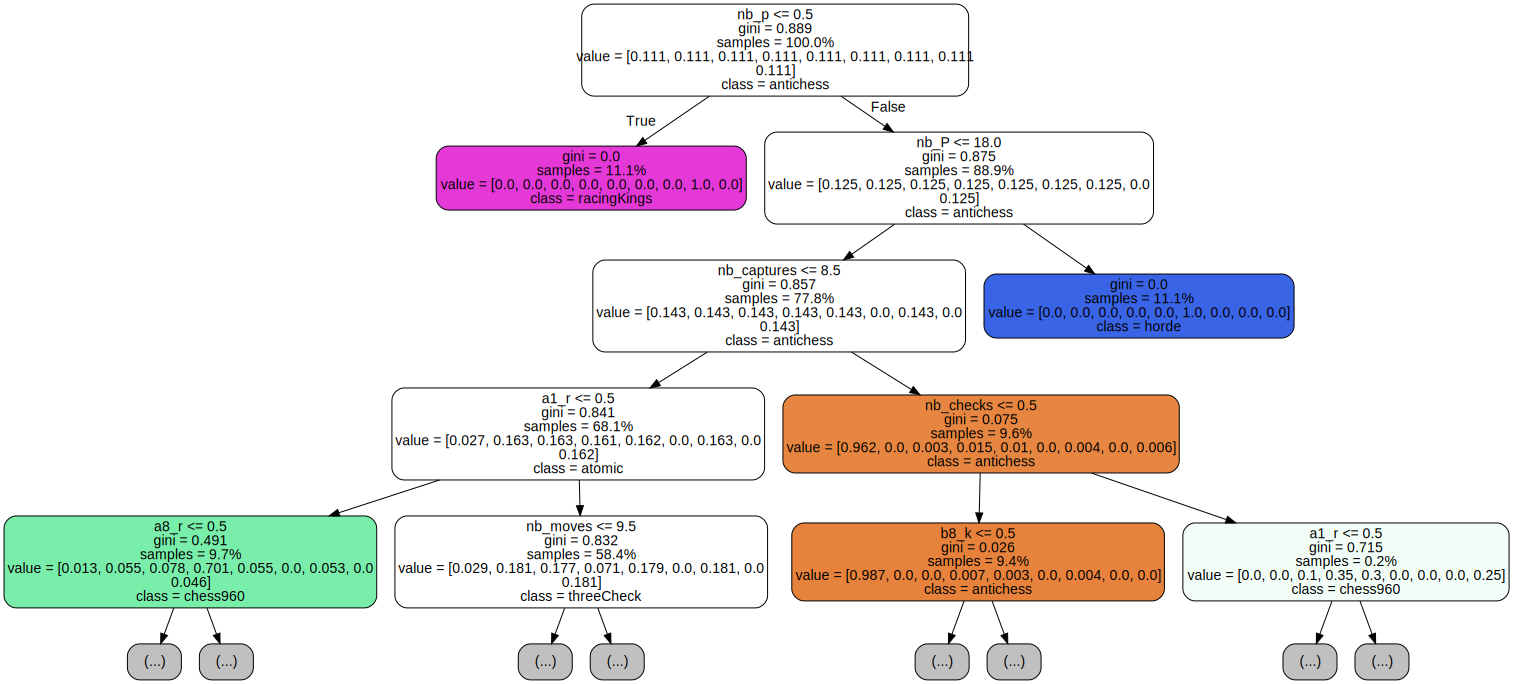

In [17]:
graphviz.Source(tree_graph, format="png") 

In [18]:
print(variants) # reminder to interpret the probabilities

['antichess', 'atomic', 'blitz', 'chess960', 'crazyhouse', 'horde', 'kingOfTheHill', 'racingKings', 'threeCheck']


Without any surprise, the two first splits enable to split the data between our two unusual variants: racingKings and horde. Only the number of pawns is enough to reach a 100% accuracy for these two variants.  
We then see that the high number of captures (9 or more) plays an important role, and favors variants such as antichess, chess960, threeCheck, crazyhouse or sometimes blitz. However, when this high number of captures if combined with no checks given, we almost already have the certitude that the variant is antichess.  
On the other side, a low number of captures (8 or less) gives much less information about the potential variants. Indeed, atomic, blitz, chess960, crazyhouse and racingKings show similar probabilities and others splits are needed. Without any surprise, these are the variants that already difficult to distinguish in the EDA. These variants are also the ones that show lower sensitivies and recall scores previously.  
We also that the position of rooks on the corner squares (especially a1 and a8) might help to predict the chess960 variant. Indeed, in other variants, we might expect the rooks to be present on these squares as the rooks are originally placed there. However, in chess960, the initial position is random which clearly decreases the probability to have rooks on these squares. 

# Logistic Regression

We now run the same procedure for different models and store the results to interpret them later.

In [19]:
# Define our steps
model = LogisticRegression()

# grid 
grid = {
    'C': np.logspace(-3, 4, 8),
}

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1,
    return_train_score=True)

In [20]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
logistic_tune_time = time.time() - start_time

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [21]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(logistic_tune_time, 1)))

,param_C,mean_test_score,std_test_score
5,100,0.838148,0.004851
6,1000,0.837654,0.004984
7,10000,0.836790,0.004807
4,10,0.832963,0.003612
3,1,0.824815,0.002451
2,0.1,0.819753,0.003381
1,0.01,0.796914,0.007325
0,0.001,0.755309,0.010696


We can expect an accuracy close to 83.8% on the testing set with the following parameters: 
{'C': 100.0}. 
The tuning time is 80.8 sec.


In [22]:
logistic = LogisticRegression(
    **grid_cv.best_params_, random_state=0)

In [23]:
start_time = time.time()
logistic.fit(X_tr, y_tr)
logistic_train_time = time.time() - start_time

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [24]:
logistic_accuracy = logistic.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(logistic_accuracy*100))

Accuracy on Testing Set: accuracy: 85.3%.


In [25]:
logistic_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
logistic_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.87,0.00,0.01,0.00,0.01,0.0,0.01,0.0,0.01
atomic,0.03,0.77,0.03,0.03,0.02,0.0,0.03,0.0,0.06
blitz,0.00,0.01,0.54,0.01,0.15,0.0,0.18,0.0,0.14
chess960,0.01,0.03,0.02,0.88,0.00,0.0,0.01,0.0,0.01
crazyhouse,0.02,0.01,0.13,0.01,0.56,0.0,0.17,0.0,0.12
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.05,0.09,0.17,0.04,0.10,0.0,0.51,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.02,0.09,0.10,0.03,0.16,0.0,0.09,0.0,0.55


In [26]:
logistic_metrics=pd.DataFrame(classification_report(logistic.predict(X_te), y_te, output_dict=True)).T.round(3)
logistic_metrics

,f1-score,precision,recall,support
antichess,0.969,0.950,0.990,96.0
atomic,0.936,0.950,0.922,103.0
blitz,0.614,0.660,0.574,115.0
chess960,0.995,1.000,0.990,101.0
crazyhouse,0.786,0.790,0.782,101.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.638,0.590,0.694,85.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.744,0.740,0.747,99.0
micro avg,0.853,0.853,0.853,900.0


Overall, the results have been improved compared to the simple decision tree. We get a better accuracy, but as well better scores for the other metrics that we explore.

# Random Forest

In [27]:
# Define our steps
model = RandomForestClassifier()

# grid 
grid = {'n_estimators': [20,100,500,750,1000],
               'max_depth': [5,10,20,50,75,100]
       } 

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1)

In [28]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
rf_tune_time = time.time() - start_time

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.7min finished


In [29]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(rf_tune_time, 1)))

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/e

,param_n_estimators,param_max_depth,mean_test_score,std_test_score
24,1000,75,0.825556,0.010942
22,500,75,0.824815,0.007743
18,750,50,0.824568,0.008267
19,1000,50,0.823457,0.008877
27,500,100,0.823210,0.007331
29,1000,100,0.822716,0.009794
23,750,75,0.822593,0.008397
13,750,20,0.821358,0.010170
12,500,20,0.821111,0.008340
28,750,100,0.821111,0.008548


We can expect an accuracy close to 82.6% on the testing set with the following parameters: 
{'max_depth': 75, 'n_estimators': 1000}. 
The tuning time is 252.9 sec.


In [30]:
rf = RandomForestClassifier(
    **grid_cv.best_params_, random_state=0)

In [31]:
start_time = time.time()
rf.fit(X_tr, y_tr)
rf_train_time = time.time() - start_time

In [32]:
rf_accuracy = rf.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(rf_accuracy*100))

Accuracy on Testing Set: accuracy: 81.9%.


In [33]:
rf_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
rf_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.87,0.00,0.01,0.00,0.01,0.0,0.01,0.0,0.01
atomic,0.03,0.77,0.03,0.03,0.02,0.0,0.03,0.0,0.06
blitz,0.00,0.01,0.54,0.01,0.15,0.0,0.18,0.0,0.14
chess960,0.01,0.03,0.02,0.88,0.00,0.0,0.01,0.0,0.01
crazyhouse,0.02,0.01,0.13,0.01,0.56,0.0,0.17,0.0,0.12
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.05,0.09,0.17,0.04,0.10,0.0,0.51,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.02,0.09,0.10,0.03,0.16,0.0,0.09,0.0,0.55


In [34]:
rf_metrics=pd.DataFrame(classification_report(rf.predict(X_te), y_te, output_dict=True)).T.round(3)
rf_metrics

,f1-score,precision,recall,support
antichess,0.941,0.950,0.931,102.0
atomic,0.911,0.920,0.902,102.0
blitz,0.589,0.630,0.553,114.0
chess960,0.995,1.000,0.990,101.0
crazyhouse,0.570,0.570,0.570,100.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.629,0.610,0.649,94.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.738,0.690,0.793,87.0
micro avg,0.819,0.819,0.819,900.0


This gets better and better! The random forest leads to improved results for all metrics, except the f1 score for the "blitz" variant that we considered as an important score as well, which is a bit disappointing.

# SVM

In [35]:
# Define our steps
model = SVC()

# grid 
grid = {'C': np.logspace(-0,5,5), # others sets of param were tested, higher C generally performed better
               'kernel': ['sigmoid', 'rbf'], # computational performance of linear kernel too bad to be considered as a good candidate
              'gamma': np.logspace(-5,0,5) # others sets of parameters were tested, lower gammas generally performed better
       }  

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1)

In [36]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
svm_tune_time = time.time() - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 38.1min finished


In [37]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(svm_tune_time, 1)))

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/e

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score
15,17.7828,rbf,0.00316228,0.867407,0.010758
23,316.228,rbf,0.000177828,0.864691,0.009159
31,5623.41,rbf,1e-05,0.863210,0.008120
30,5623.41,sigmoid,1e-05,0.862593,0.009480
22,316.228,sigmoid,0.000177828,0.862593,0.009309
32,5623.41,sigmoid,0.000177828,0.852099,0.008324
40,100000,sigmoid,1e-05,0.851852,0.008346
33,5623.41,rbf,0.000177828,0.851605,0.007833
41,100000,rbf,1e-05,0.850864,0.006836
25,316.228,rbf,0.00316228,0.848519,0.009788


We can expect an accuracy close to 86.7% on the testing set with the following parameters: 
{'C': 17.78279410038923, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}. 
The tuning time is 2295.7 sec.


In [38]:
svm = SVC(
    **grid_cv.best_params_, random_state=0, probability=True
)

In [39]:
start_time = time.time()
svm.fit(X_tr, y_tr)
svm_train_time = time.time() - start_time

In [40]:
svm_accuracy = svm.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(svm_accuracy*100))

Accuracy on Testing Set: accuracy: 88.1%.


In [41]:
svm_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
svm_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.87,0.00,0.01,0.00,0.01,0.0,0.01,0.0,0.01
atomic,0.03,0.77,0.03,0.03,0.02,0.0,0.03,0.0,0.06
blitz,0.00,0.01,0.54,0.01,0.15,0.0,0.18,0.0,0.14
chess960,0.01,0.03,0.02,0.88,0.00,0.0,0.01,0.0,0.01
crazyhouse,0.02,0.01,0.13,0.01,0.56,0.0,0.17,0.0,0.12
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.05,0.09,0.17,0.04,0.10,0.0,0.51,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.02,0.09,0.10,0.03,0.16,0.0,0.09,0.0,0.55


In [42]:
svm_metrics=pd.DataFrame(classification_report(svm.predict(X_te), y_te, output_dict=True)).T.round(3)
svm_metrics

,f1-score,precision,recall,support
antichess,0.970,0.980,0.961,102.0
atomic,0.985,0.990,0.980,101.0
blitz,0.655,0.720,0.600,120.0
chess960,0.995,0.990,1.000,99.0
crazyhouse,0.826,0.760,0.905,84.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.701,0.690,0.711,97.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.812,0.800,0.825,97.0
micro avg,0.881,0.881,0.881,900.0


The results are here clearly above what we have had until now. This results might well be the one to beat in the rest of our analysis and will serve as a benchmark.  
But this comes with the cost of a higher complexity and the models have taken a long time to be tuned. 

# Neural Network with Sklearn

In [43]:
# Define our steps
model = MLPClassifier()

# grid 
grid = {'hidden_layer_sizes': [5,10,15,20,50,100],
        'alpha': np.logspace(-5,5,5),
        'solver': ['adam', 'sgd'],
        'activation': ['logistic', 'relu']
       }  

# Grid search
grid_cv = GridSearchCV(
    model, 
    grid, 
    cv=kfold,    
    verbose = 1,
    n_jobs = -1)

In [44]:
start_time = time.time()
grid_cv.fit(X_tr, y_tr)
nnet_tune_time = time.time() - start_time

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 23.5min finished


In [45]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# getting the columns of interest:
cols = []
for i in range(len(grid.keys())):
    cols.append('param_'+list(grid.keys())[i]) 
cols.append('mean_test_score')
cols.append('std_test_score')

# printing the results
display(cv_results[cols].sort_values('mean_test_score', ascending=False).head(10))
print("We can expect an accuracy close to {:.1f}% on the testing set with the following parameters: \n{}. \nThe tuning time is {} sec.".format(max(cv_results['mean_test_score']*100), grid_cv.best_params_, round(nnet_tune_time, 1)))

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/e

,param_hidden_layer_sizes,param_alpha,param_solver,param_activation,mean_test_score,std_test_score
92,50,1,adam,relu,0.841358,0.010083
94,100,1,adam,relu,0.835556,0.011807
90,20,1,adam,relu,0.833704,0.007331
88,15,1,adam,relu,0.832840,0.006165
86,10,1,adam,relu,0.832222,0.008165
83,100,0.00316228,sgd,relu,0.829383,0.003326
71,100,1e-05,sgd,relu,0.828395,0.006717
81,50,0.00316228,sgd,relu,0.827901,0.006911
69,50,1e-05,sgd,relu,0.826914,0.007930
22,100,0.00316228,adam,logistic,0.826667,0.010551


We can expect an accuracy close to 84.1% on the testing set with the following parameters: 
{'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': 50, 'solver': 'adam'}. 
The tuning time is 1416.4 sec.


In [46]:
nnet = MLPClassifier(
    **grid_cv.best_params_, random_state=0)

In [47]:
start_time = time.time()
nnet.fit(X_tr, y_tr)
nnet_train_time = time.time() - start_time

In [48]:
nnet_accuracy = nnet.score(X_te, y_te)
print('Accuracy on Testing Set: accuracy: {:.1f}%.'.format(nnet_accuracy*100))

Accuracy on Testing Set: accuracy: 85.4%.


In [49]:
nnet_conf=pd.DataFrame(confusion_matrix(dt.predict(X_te), y_te), index=variants, columns=variants)/100
nnet_conf

,antichess,atomic,blitz,chess960,crazyhouse,horde,kingOfTheHill,racingKings,threeCheck
antichess,0.87,0.00,0.01,0.00,0.01,0.0,0.01,0.0,0.01
atomic,0.03,0.77,0.03,0.03,0.02,0.0,0.03,0.0,0.06
blitz,0.00,0.01,0.54,0.01,0.15,0.0,0.18,0.0,0.14
chess960,0.01,0.03,0.02,0.88,0.00,0.0,0.01,0.0,0.01
crazyhouse,0.02,0.01,0.13,0.01,0.56,0.0,0.17,0.0,0.12
horde,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.0,0.00
kingOfTheHill,0.05,0.09,0.17,0.04,0.10,0.0,0.51,0.0,0.11
racingKings,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.00
threeCheck,0.02,0.09,0.10,0.03,0.16,0.0,0.09,0.0,0.55


In [50]:
nnet_metrics=pd.DataFrame(classification_report(nnet.predict(X_te), y_te, output_dict=True)).T.round(3)
nnet_metrics

,f1-score,precision,recall,support
antichess,0.970,0.960,0.980,98.0
atomic,0.945,0.950,0.941,101.0
blitz,0.657,0.710,0.612,116.0
chess960,0.975,0.970,0.980,99.0
crazyhouse,0.738,0.720,0.758,95.0
horde,1.000,1.000,1.000,100.0
kingOfTheHill,0.657,0.660,0.653,101.0
racingKings,1.000,1.000,1.000,100.0
threeCheck,0.758,0.720,0.800,90.0
micro avg,0.854,0.854,0.854,900.0


Our last models performs very well as well. The obtained accuracy and the other relevant metrics are just a bit below what was obtained for the random forest.  

# Results

We now retrieve the different metrics that were considered as the most important for our analysis.

In [51]:
dt_scores_avg=list(dt_metrics.loc['weighted avg',:])[:3]
dt_scores_blitz=list(dt_metrics.loc['blitz',:])
logistic_scores_avg=list(logistic_metrics.loc['weighted avg',:])[:3]
logistic_scores_blitz=list(logistic_metrics.loc['blitz',:])
rf_scores_avg=list(rf_metrics.loc['weighted avg',:])[:3]
rf_scores_blitz=list(rf_metrics.loc['blitz',:])
svm_scores_avg=list(svm_metrics.loc['weighted avg',:])[:3]
svm_scores_blitz=list(svm_metrics.loc['blitz',:])
nnet_scores_avg=list(nnet_metrics.loc['weighted avg',:])[:3]
nnet_scores_blitz=list(nnet_metrics.loc['blitz',:])

The overall results when working on the full dataset are presented below. 

In [53]:
results_full=pd.DataFrame({
              'decision tree': [dt_accuracy, dt_tune_time, dt_train_time, dt_scores_avg[0], dt_scores_avg[1], dt_scores_avg[2], dt_scores_blitz[0], dt_scores_blitz[1], dt_scores_blitz[2], dt_scores_blitz[3]],
              'logistic': [logistic_accuracy, logistic_tune_time, logistic_train_time, logistic_scores_avg[0], logistic_scores_avg[1], logistic_scores_avg[2], logistic_scores_blitz[0], logistic_scores_blitz[1], logistic_scores_blitz[2], logistic_scores_blitz[3]],
              'random forest': [rf_accuracy, rf_tune_time, rf_train_time, rf_scores_avg[0], rf_scores_avg[1], rf_scores_avg[2], rf_scores_blitz[0], rf_scores_blitz[1], rf_scores_blitz[2], rf_scores_blitz[3]],
              'SVM': [svm_accuracy, svm_tune_time, svm_train_time, svm_scores_avg[0], svm_scores_avg[1], svm_scores_avg[2], svm_scores_avg[0], svm_scores_blitz[1], svm_scores_blitz[2], svm_scores_blitz[3]],
              'NN': [nnet_accuracy, nnet_tune_time, nnet_train_time, nnet_scores_avg[0], nnet_scores_avg[1], nnet_scores_avg[2], nnet_scores_blitz[0], nnet_scores_blitz[1], nnet_scores_blitz[2], nnet_scores_blitz[3]],
}, index = ['Accuracy', 'Tuning time', 'Training time', 'f1_avg', 'precision_avg', 'recall_avg', 'f1_blitz', 'precision_blitz', 'recall_blitz', 'support_blitz']).round(3).T.sort_values('Accuracy', ascending=False)
results_full

,Accuracy,Tuning time,Training time,f1_avg,precision_avg,recall_avg,f1_blitz,precision_blitz,recall_blitz,support_blitz
SVM,0.881,2295.734,54.954,0.880,0.881,0.881,0.880,0.72,0.600,120.0
NN,0.854,1416.433,8.049,0.853,0.854,0.854,0.657,0.71,0.612,116.0
logistic,0.853,80.750,10.718,0.853,0.855,0.853,0.614,0.66,0.574,115.0
random forest,0.819,252.935,25.133,0.819,0.820,0.819,0.589,0.63,0.553,114.0
decision tree,0.742,7.227,0.280,0.739,0.737,0.742,0.532,0.54,0.524,103.0


Even if we do not have any real benchmark, the result seems very good. The baseline of approximately 40% has been completely outperformed and we end up with a promising accuracy of more than 88%.  

The results are stored and will be compared to the results when using the other approaches (modelling on df_eng, modelling using PCA, nested models or neural networks with more features) in the notebook "Capstone project - Results.ipynb".

In [54]:
results_full.to_pickle('datasets/results_full')